## Informe Análisis Descriptivo y Comparativo — ABC Corporation
**Objetivo**: Analizar el contexto general de la empresa usando visualizaciones en Python (**Matplotlib & Seaborn**), resaltando tendencias, áreas de mejora y fortalezas para decisiones informadas.



In [2]:
# --- Imports base ---
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import pandas.api.types as pdt
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import Markdown, display

# --- Desactivar todos los warnings ---
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # suprime avisos de "SettingWithCopyWarning"
plt.rcParams.update({"axes.unicode_minus": False})  # evita símbolos raros en ticks negativos

# --- Estética global ---
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "semibold"

# --- Paletas reutilizables ---
PALETTE_CAT = sns.color_palette("colorblind")           # categóricas
PALETTE_ORD = sns.color_palette("viridis", as_cmap=False)  # ordinales
PALETTE_DIV = "vlag"                                    # divergente para correlaciones

# --- Helpers reutilizables ---
def md(title: str, bullets: list[str]):
    """Bloque Markdown con título y viñetas."""
    text = f"### {title}\n" + "\n".join(f"- {b}" for b in bullets)
    display(Markdown(text))

def pct_fmt(y, _pos):
    """Formateo de ticks como porcentaje entero."""
    return f"{y:.0f}%"

def attrition_to_bin(s: pd.Series) -> pd.Series:
    """Mapea Yes/No/True/False/1/0 -> 1/0; mantiene NaN si no reconoce."""
    if s.dtype == "object":
        m = {"Yes":1,"Y":1,"True":1,"TRUE":1,"1":1,
             "No":0,"N":0,"False":0,"FALSE":0,"0":0}
        return s.map(lambda x: m.get(str(x), np.nan)).astype(float)
    return pd.to_numeric(s, errors="coerce")

def annotate_bars(ax, fmt="{:.1f}%"):
    """Añade etiquetas de valor encima de cada barra (útil en % de rotación)."""
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(fmt.format(h),
                        (p.get_x() + p.get_width()/2, h),
                        ha="center", va="bottom", fontsize=9,
                        xytext=(0, 3), textcoords="offset points")

# --- Paths y carga de datos ---
DATA_PATH = r"Archivo limpio.parquet"   # si usas CSV: "Archivo_limpio.csv"
OUT_DIR = Path(r"salidas_fase3_ABC")
FIG_DIR = OUT_DIR / "figs"
TAB_DIR = OUT_DIR / "tables"
OUT_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR.mkdir(exist_ok=True, parents=True)

# Carga (Parquet por defecto). Si prefieres CSV, usa pd.read_csv.
df = pd.read_parquet(DATA_PATH)  # requiere pyarrow o fastparquet
df.shape


(1614, 32)

In [3]:
# Mapeo específico de las columnas

resolved = {
    # Satisfacción (usaremos Job satisfaction como principal y más abajo un pack de dimensiones)
    "satisfaction_primary": "Job satisfaction",
    "satisfaction_dims": [
        "Job satisfaction",
        "Environment satisfaction",
        "Relationship satisfaction",
        "Work life balance",
        "Job involvement",
    ],
    # Rotación / Churn
    "attrition": "Attrition",
    # Agrupadores disponibles
    "jobrole": "Job role",
    "gender": "Gender",
    "marital": "Marital status",
    "overtime": "Overtime",
    "education": "Education",
    "education_field": "Education field",
    "business_travel": "Business travel",
    "remote_work": "Remote work",
    # Métricas numéricas interesantes
    "monthly_income": "Monthly income",
    "salary_alt": "Salary",  # por si quieres comparar ambas
    "monthly_rate": "Monthly rate",
    "daily_rate": "Daily rate",
    "distance_home": "Distance from home",
    "percent_salary_hike": "Percent salary hike",
    "performance_rating": "Performance rating",
    "training_times_last_year": "Training times last year",
    "stock_option_level": "Stock option level",
    "job_level": "Job level",
    "total_working_years": "Total working years",
    "years_at_company": "Years at company",
    "years_since_last_promotion": "Years since last promotion",
    "years_with_current_manager": "Years with current manager",
    "standard_hours": "Standard hours",
    # Campos de identificación / auxiliares
    "employee_number": "Employee number",
    "date_birth": "Date birth",
}

# Verificación de que las columnas existen (por si alguna faltara)
missing = [v for v in resolved.values() if isinstance(v, str) and v not in df.columns]
if missing:
    print("⚠️ Las siguientes columnas del mapeo no están en el DataFrame:", missing)

# Clasificación de tipos con pandas (soporta Int64/Float64 "nullable")
def is_cat(s: pd.Series) -> bool:
    return (
        pdt.is_categorical_dtype(s)
        or pdt.is_object_dtype(s)
        or pdt.is_bool_dtype(s)
        or pdt.is_string_dtype(s)
    )

def is_num(s: pd.Series) -> bool:
    return pdt.is_numeric_dtype(s)

cat_cols = [c for c in df.columns if is_cat(df[c])]
num_cols = [c for c in df.columns if is_num(df[c]) and c not in cat_cols]

# Vista rápida
len(cat_cols), len(num_cols), resolved["satisfaction_primary"], resolved["attrition"], resolved["jobrole"]



(9, 23, 'Job satisfaction', 'Attrition', 'Job role')

In [4]:
df['Education'].unique()[:10]

<IntegerArray>
[3, 4, 2, 1, 5]
Length: 5, dtype: Int64

In [5]:
df['Job level'].unique()[:10]

<IntegerArray>
[5, 4, 3, 2, 1]
Length: 5, dtype: Int64

In [6]:
df['Job involvement'].unique()[:10]

<IntegerArray>
[3, 2, 4, 1]
Length: 4, dtype: Int64

In [7]:
df['Job satisfaction'].unique()[:10]

<IntegerArray>
[3, 4, 1, 2]
Length: 4, dtype: Int64

In [8]:
df['Work life balance'].unique()[:10]

<IntegerArray>
[3, 2, 4, 1]
Length: 4, dtype: Int64

In [9]:
df['Relationship satisfaction'].unique()[:10]

<IntegerArray>
[3, 1, 4, 2]
Length: 4, dtype: Int64

In [10]:
df['Environment satisfaction'].unique()[:10]

<IntegerArray>
[1, 3, 4, 2, 42, 37, 35, 25, 27, 31]
Length: 10, dtype: Int64


Antes de nada, necesitamos volver a tratar las columnas cuya tipo ideal para la graficación es el de categóricas

In [11]:
import pandas as pd
from pandas.api.types import CategoricalDtype

def make_satisfaction_categoricals(df: pd.DataFrame, in_place: bool = True, suffix: str = "_cat"):
    """
    Convierte las dimensiones de satisfacción a categóricas ordenadas con etiquetas en español.
    - Para 'Environment satisfaction': comprime cualquier valor fuera de 1..4 a 4 ("Muy alta").
    - Para el resto: espera valores 1..4 y mapea a etiquetas.
    - in_place=True sobrescribe; False crea columnas nuevas con sufijo.
    Devuelve un dict {columna_final: lista_de_categorías}.
    """
    dims = [
        "Job satisfaction",
        "Environment satisfaction",
        "Relationship satisfaction",
        "Work life balance",
        "Job involvement",
    ]

    labels_1_4 = {1: "Muy baja", 2: "Baja", 3: "Alta", 4: "Muy alta"}
    order_1_4  = ["Muy baja", "Baja", "Alta", "Muy alta"]  # orden visual

    summary = {}

    for col in dims:
        if col not in df.columns:
            continue

        s = pd.to_numeric(df[col], errors="coerce")

        if col == "Environment satisfaction":
            # Todo lo que no sea 1..4 → 4 (Muy alta)
            s = s.where(s.isin([1,2,3,4]), 4)

        # Limita al rango 1..4 y mapea a texto
        s = s.where(s.isin([1,2,3,4]))
        s_lab = s.map(labels_1_4)

        # Categórica ordenada
        cat_dtype = CategoricalDtype(categories=order_1_4, ordered=True)
        s_cat = s_lab.astype("string").astype(cat_dtype)

        out_col = col if in_place else f"{col}{suffix}"
        df[out_col] = s_cat
        summary[out_col] = list(s_cat.cat.categories)

    return summary


In [20]:
_ = make_satisfaction_categoricals(df, in_place=True)
# Ahora vuelve a ejecutar las celdas de gráficas: las barras de "Environment satisfaction" aparecerán correctamente.

### COMPARATIVAS RELACIONALES

#### Comparativa de múltiples dimensiones de satisfacción por Rol y modalidad de trabajo remoto

En esta sección analizamos, para varias **dimensiones de la satisfacción laboral**  
(por ejemplo: *Job satisfaction*, *Environment satisfaction*, *Relationship satisfaction*, etc.),  
cómo se distribuyen estas valoraciones **entre los principales roles de la empresa**  
y también cómo varían **según la modalidad de trabajo remoto**.

Este análisis permite detectar **áreas (roles o modalidades) con fortalezas o debilidades concretas** en alguna de las dimensiones de satisfacción, más allá de la media global.


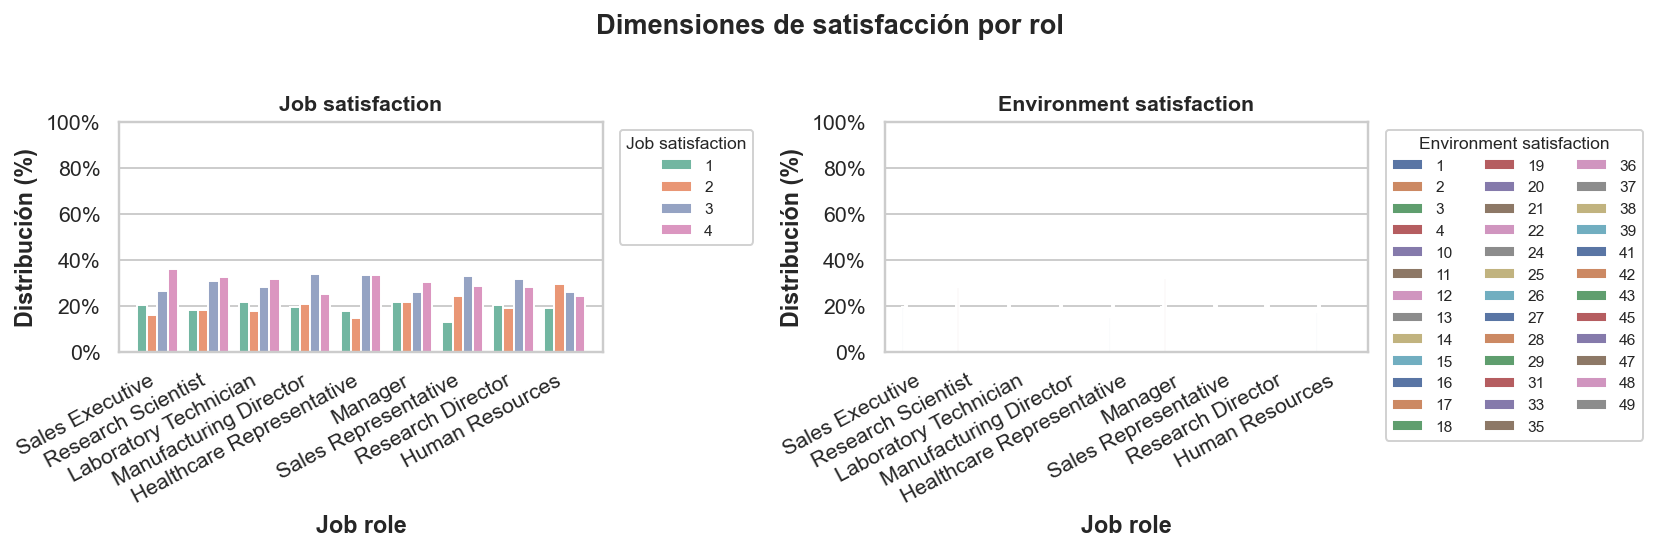

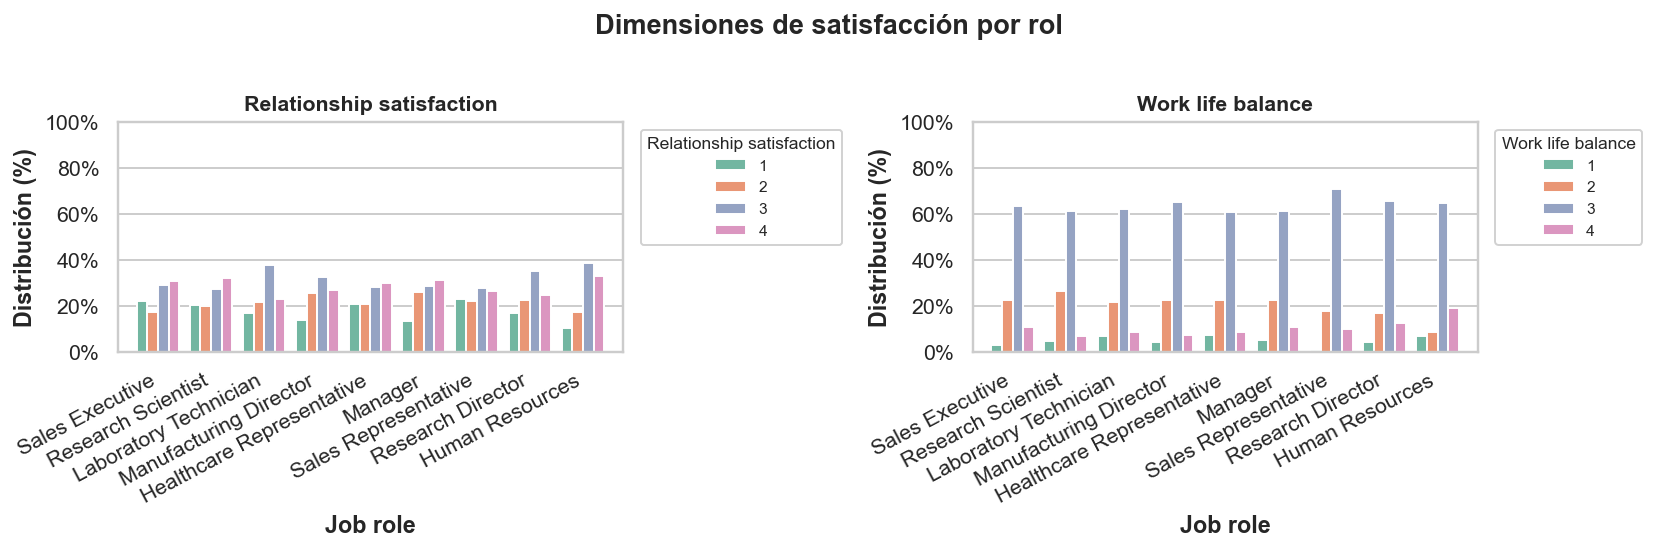

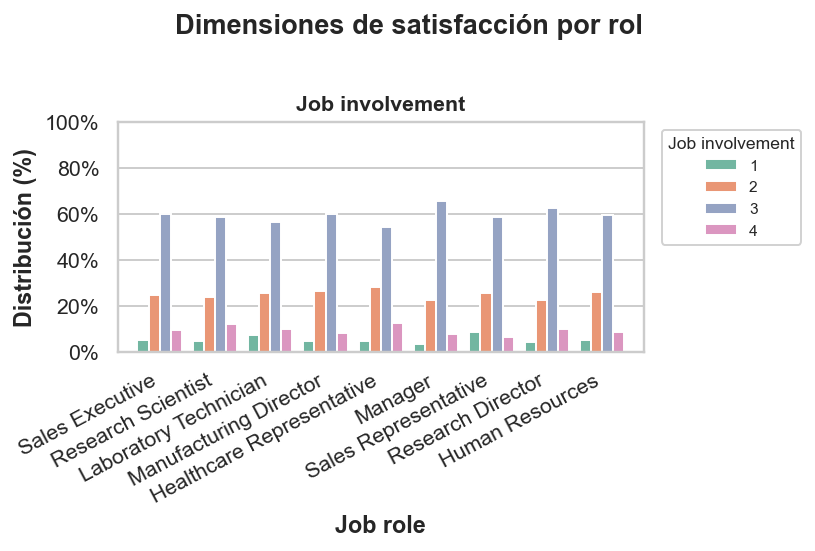

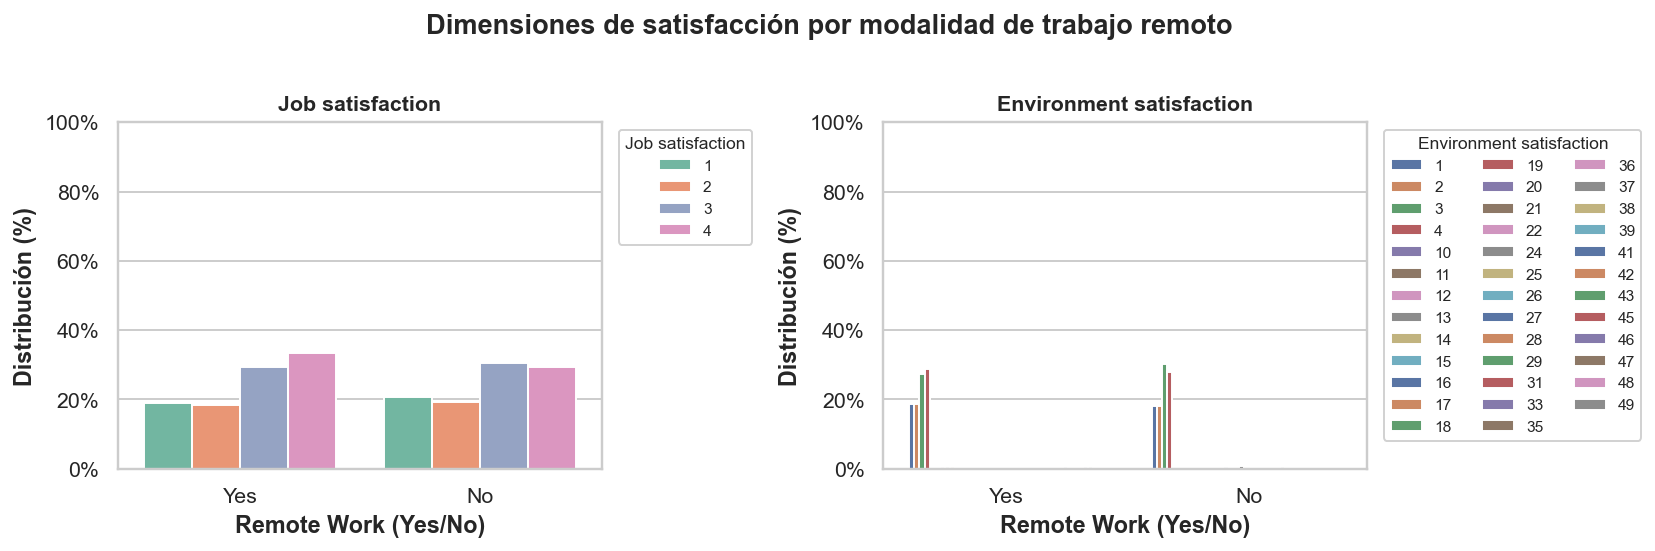

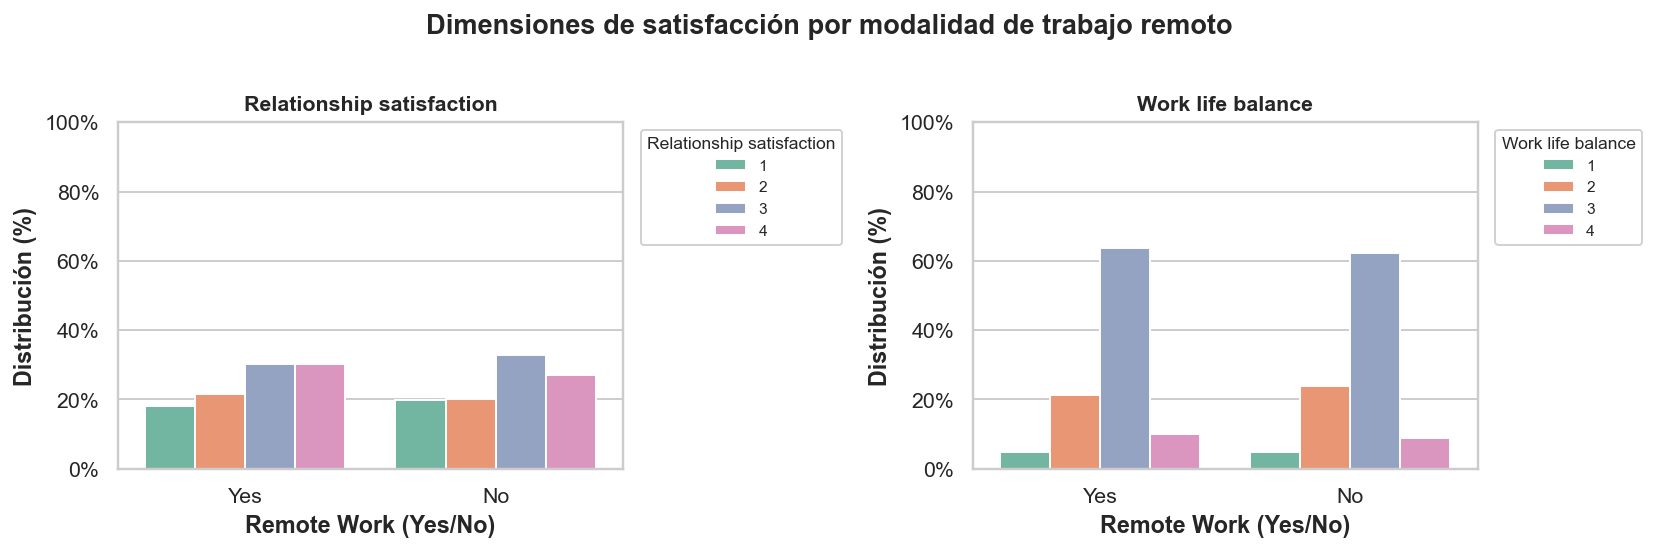

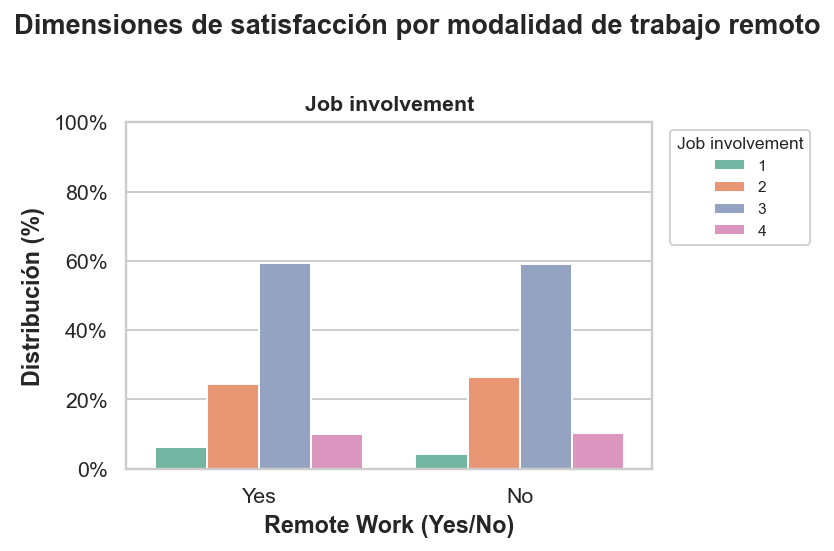

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")
PALETTE_CAT = sns.color_palette("Set2")

# =====================================================
# Dimensiones de satisfacción (sólo estas)
# =====================================================
dims_all = [
    "Job satisfaction",
    "Environment satisfaction",
    "Relationship satisfaction",
    "Work life balance",
    "Job involvement",
]

# =====================================================
# Helpers reutilizables
# =====================================================
def chunk_list(seq, pattern=(2,2,1)):
    out, i = [], 0
    while i < len(seq):
        for k in pattern:
            if i >= len(seq): break
            out.append(seq[i:i+k])
            i += k
    return out

def hue_order_from_col(series: pd.Series):
    """Si es categórica, usa su orden; si no, ordena por texto."""
    if pd.api.types.is_categorical_dtype(series):
        return [str(x) for x in series.cat.categories]
    vals = series.dropna().astype(str).unique().tolist()
    return sorted(vals, key=lambda x: (len(x), x))

def build_pct(df, group_col, dim_col):
    """Genera tabla plana de porcentajes (sin MultiIndex)."""
    g = df[[group_col, dim_col]].copy()
    g[group_col] = g[group_col].astype("string")
    g[dim_col] = g[dim_col].astype("string")

    grp = (
        g.groupby([group_col, dim_col], dropna=False, observed=True)
         .size()
         .reset_index(name="n")
    )
    if grp.empty:
        return grp

    grp["pct"] = grp["n"] / grp.groupby(group_col, observed=True)["n"].transform("sum") * 100
    return grp

def tidy_axes_x(ax, rotation):
    if rotation == 0:
        ax.margins(x=0.06)
        for lab in ax.get_xticklabels():
            lab.set_rotation(0); lab.set_ha("center"); lab.set_va("top")
    else:
        ax.margins(x=0.04)
        for lab in ax.get_xticklabels():
            lab.set_rotation(rotation); lab.set_ha("right"); lab.set_va("top")

def legend_outside(ax, title, n_items):
    ncols_leg = 3 if n_items > 8 else 1
    leg = ax.legend(title=title, fontsize=8, title_fontsize=9,
                    loc="upper left", bbox_to_anchor=(1.02, 1),
                    frameon=True, ncol=ncols_leg)
    leg.get_frame().set_alpha(0.9)

def plot_block(df, group_col, dims_block, title, x_label, rotation, file_stub):
    k = len(dims_block)
    cols = 2 if k > 1 else 1
    rows = (k + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, dim in zip(axes, dims_block):
        if dim not in df.columns:
            ax.axis("off"); ax.set_title(dim); continue

        pct = build_pct(df, group_col, dim)
        if pct.empty:
            ax.axis("off"); ax.set_title(dim); continue

        # Orden del hue
        if pd.api.types.is_categorical_dtype(df[dim]):
            hue_order = [str(x) for x in df[dim].cat.categories if str(x) in set(pct[dim])]
        else:
            hue_order = hue_order_from_col(pct[dim])

        if not hue_order:
            ax.axis("off"); ax.set_title(dim); continue

        # Orden del eje X
        x_order = df[group_col].astype("string").value_counts().index.tolist()

        # Paleta consistente
        palette = sns.color_palette("Set2", len(hue_order)) if len(hue_order) <= len(PALETTE_CAT) else sns.color_palette(None, len(hue_order))

        sns.barplot(
            data=pct,
            x=group_col, y="pct",
            hue=dim, hue_order=hue_order,
            order=x_order,
            palette=palette,
            errorbar=None,
            ax=ax
        )

        ax.set_title(dim, fontsize=11, fontweight="semibold")
        ax.set_xlabel(x_label)
        ax.set_ylabel("Distribución (%)")
        ax.yaxis.set_major_formatter(PercentFormatter(100))
        ax.set_ylim(0, 100)
        tidy_axes_x(ax, rotation)
        legend_outside(ax, dim, len(hue_order))

    for extra_ax in axes[len(dims_block):]:
        extra_ax.axis("off")

    fig.suptitle(title, fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(FIG_DIR / f"{file_stub}.png", dpi=150)
    plt.show()

# =====================================================
# 1️⃣ COMPARATIVA — POR ROL
# =====================================================
if resolved["jobrole"] in df.columns:
    top_roles = df[resolved["jobrole"]].value_counts().head(12).index
    base_role = df[df[resolved["jobrole"]].isin(top_roles)].copy()
    for i, dims_block in enumerate(chunk_list(dims_all, (2,2,1)), start=1):
        plot_block(
            base_role,
            group_col=resolved["jobrole"],
            dims_block=dims_block,
            title="Dimensiones de satisfacción por rol",
            x_label="Job role",
            rotation=28,
            file_stub=f"sat_dims_by_role_block{i}"
        )

# =====================================================
# 2️⃣ COMPARATIVA — POR MODALIDAD DE TRABAJO REMOTO
# =====================================================
if resolved["remote_work"] in df.columns:
    base_rw = df.copy()
    rw_vals = base_rw[resolved["remote_work"]].astype("string").str.strip().str.lower()
    if {"yes", "no"}.issubset(set(rw_vals.dropna().unique())):
        base_rw[resolved["remote_work"]] = base_rw[resolved["remote_work"]].map(
            lambda x: "Yes" if str(x).strip().lower()=="yes" else (
                "No" if str(x).strip().lower()=="no" else str(x))
        )

    for i, dims_block in enumerate(chunk_list(dims_all, (2,2,1)), start=1):
        plot_block(
            base_rw,
            group_col=resolved["remote_work"],
            dims_block=dims_block,
            title="Dimensiones de satisfacción por modalidad de trabajo remoto",
            x_label="Remote Work (Yes/No)",
            rotation=0,
            file_stub=f"sat_dims_by_remote_block{i}"
        )


### Interpretación de los resultados

- **Por Rol:**  
  Se observan diferencias claras entre roles. Algunos destacan por tener **niveles consistentemente altos en varias dimensiones de satisfacción**, lo que indica buen alineamiento entre expectativas, condiciones de trabajo y motivación.  
  Otros roles muestran **puntuaciones bajas en una o varias dimensiones específicas** (por ejemplo, menor *Work–Life Balance* o menor *Environment Satisfaction*), lo que puede señalar necesidades de intervención focalizada (ajuste de carga, liderazgo, entorno de trabajo, etc.).

- **Por modalidad de trabajo remoto:**  
  Comparando personas con y sin teletrabajo, se aprecian **diferencias en ciertas dimensiones** (por ejemplo, *Work–Life Balance* suele ser más favorable en quienes teletrabajan).  
  No obstante, otras dimensiones (como *Relationship satisfaction*) pueden ser **más bajas en remoto**, posiblemente por menor interacción presencial.

> En conjunto, este análisis ayuda a **priorizar políticas diferenciadas por rol y modalidad de trabajo**: reforzar prácticas que mantienen alta la satisfacción en ciertos colectivos y planificar acciones específicas para los que muestran debilidades concretas.


## Rotación (Attrition) por categorías y antigüedad

En este bloque comparamos la **tasa de rotación** entre distintos grupos
(**Rol, Overtime, Educación, Viajes de negocio, Género, Estado civil, Trabajo remoto**)
y analizamos cómo varía según **tramos de antigüedad en la empresa**.

El objetivo es detectar **colectivos con mayor propensión a abandonar** la organización y
**momentos críticos** del ciclo de vida del empleado donde conviene actuar (onboarding, consolidación, etc.).

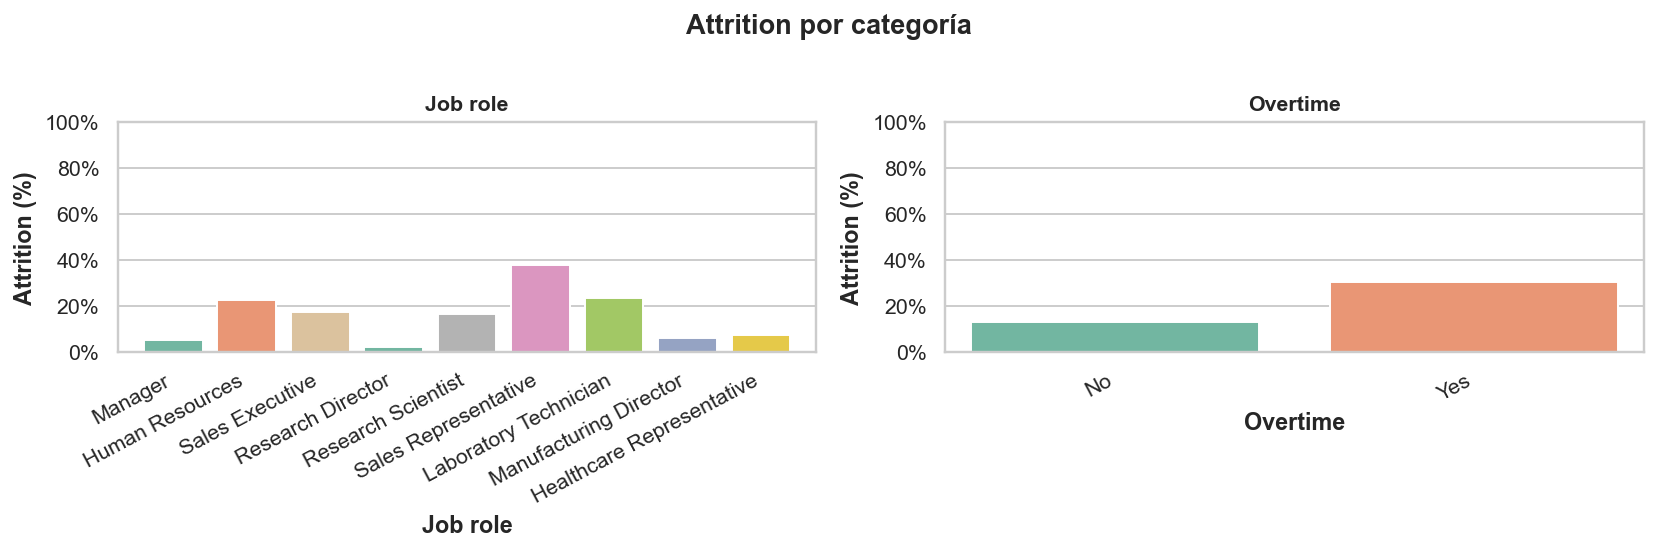

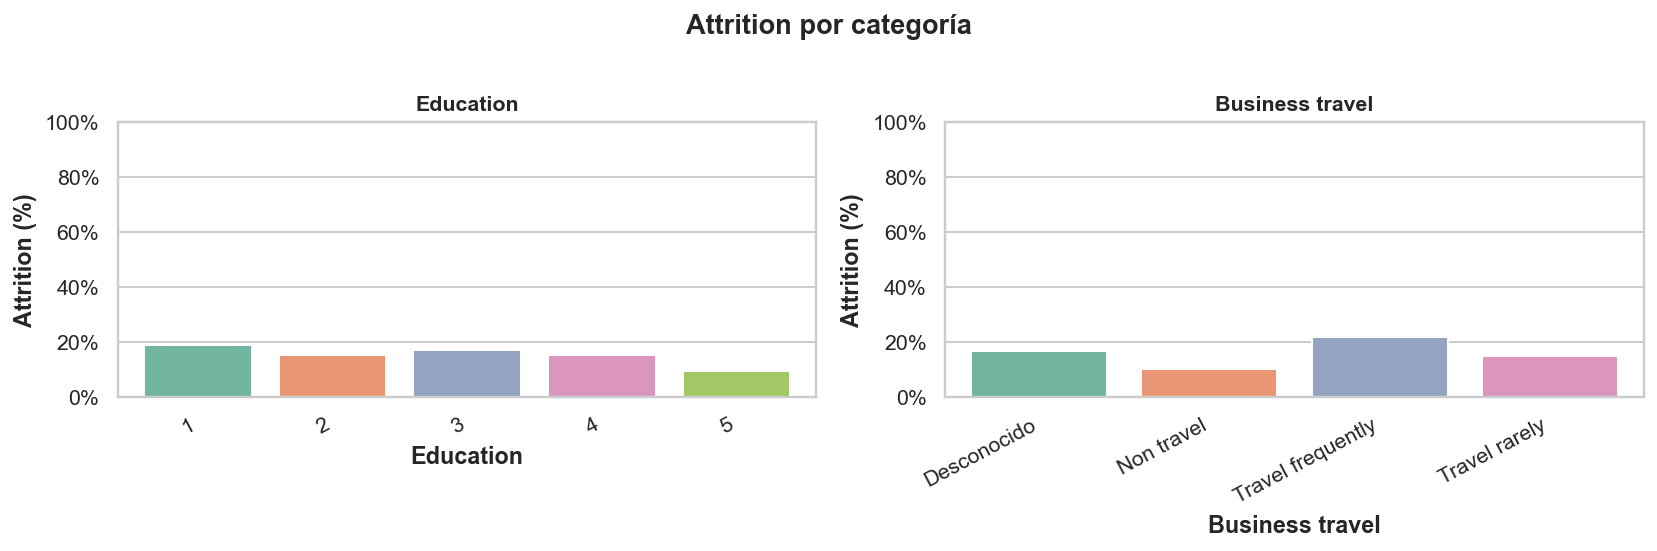

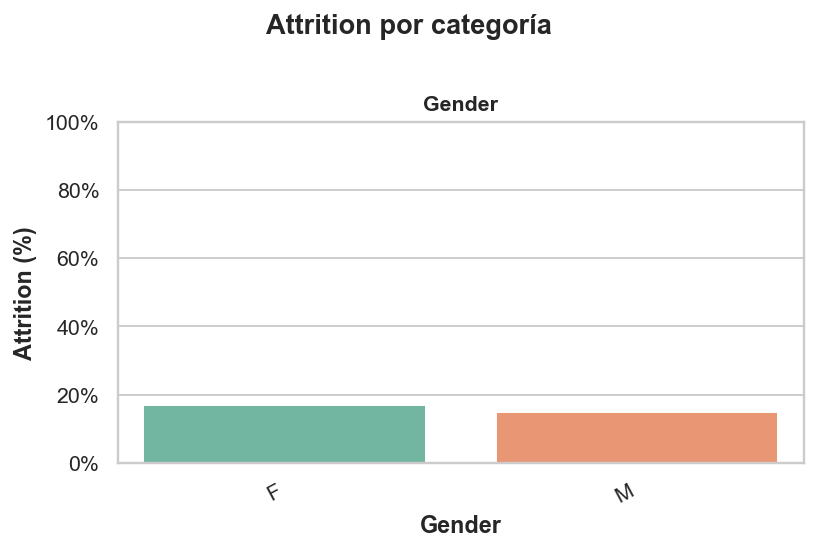

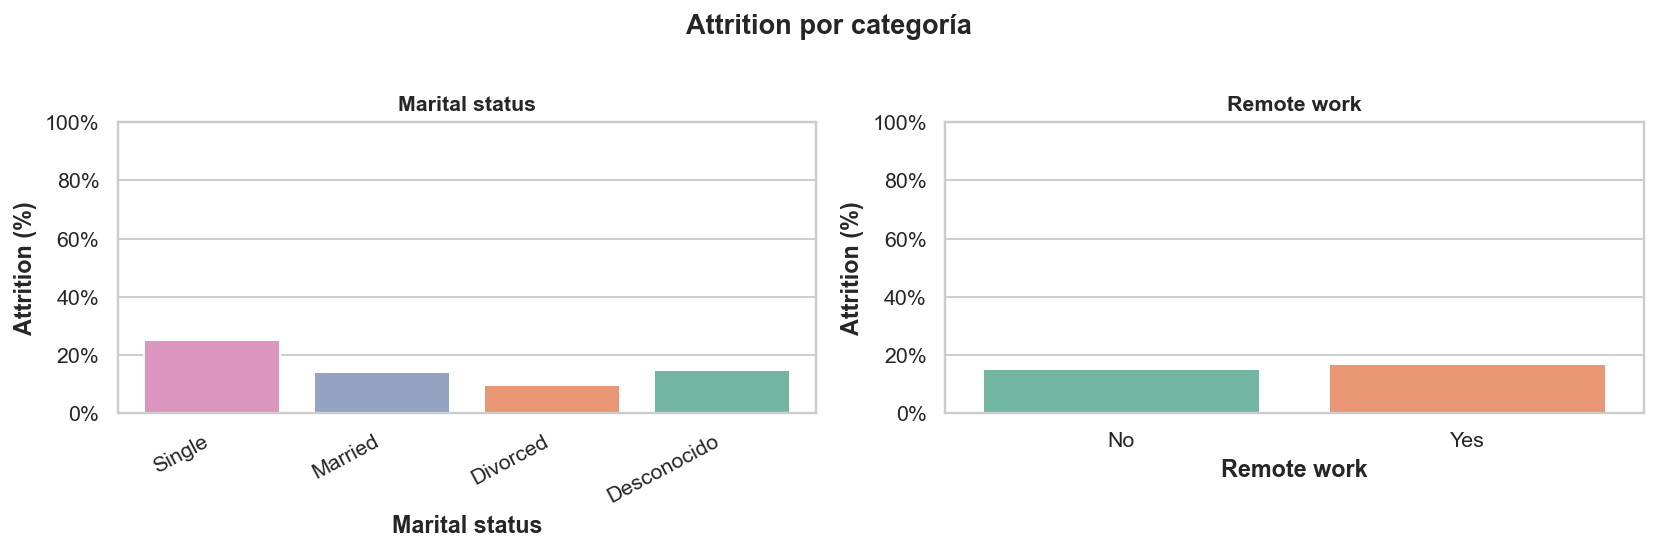

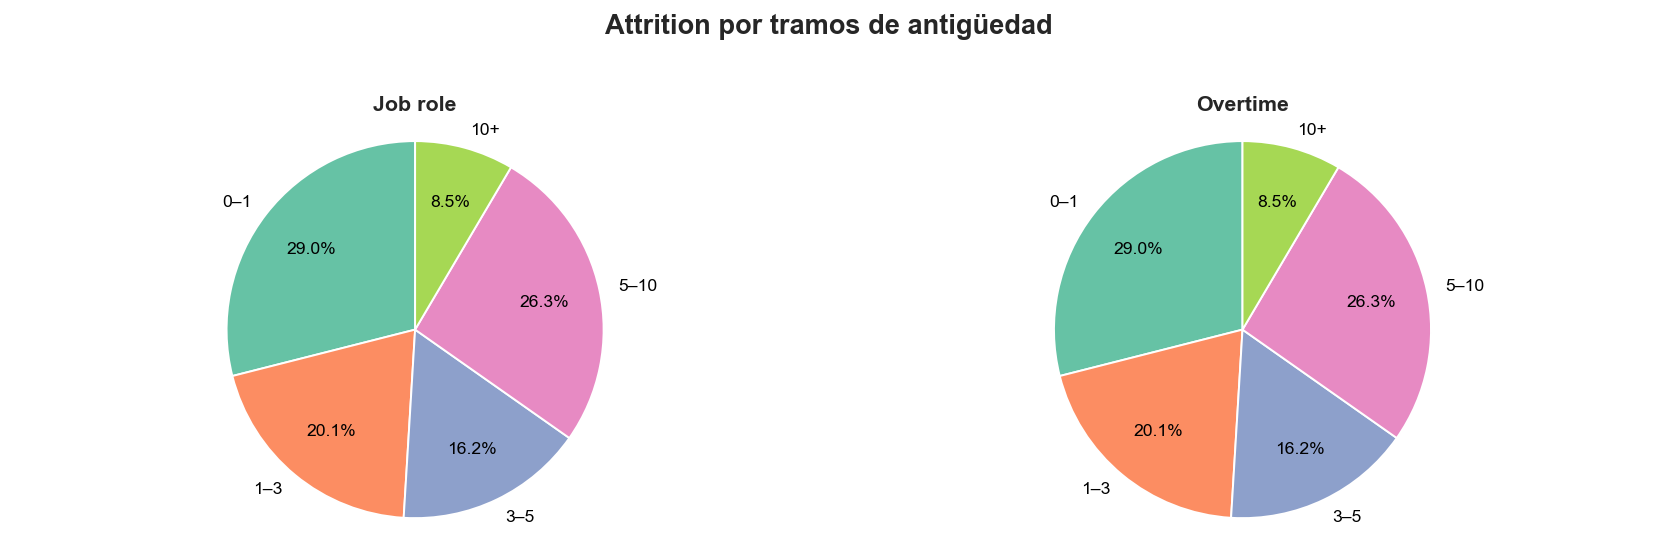

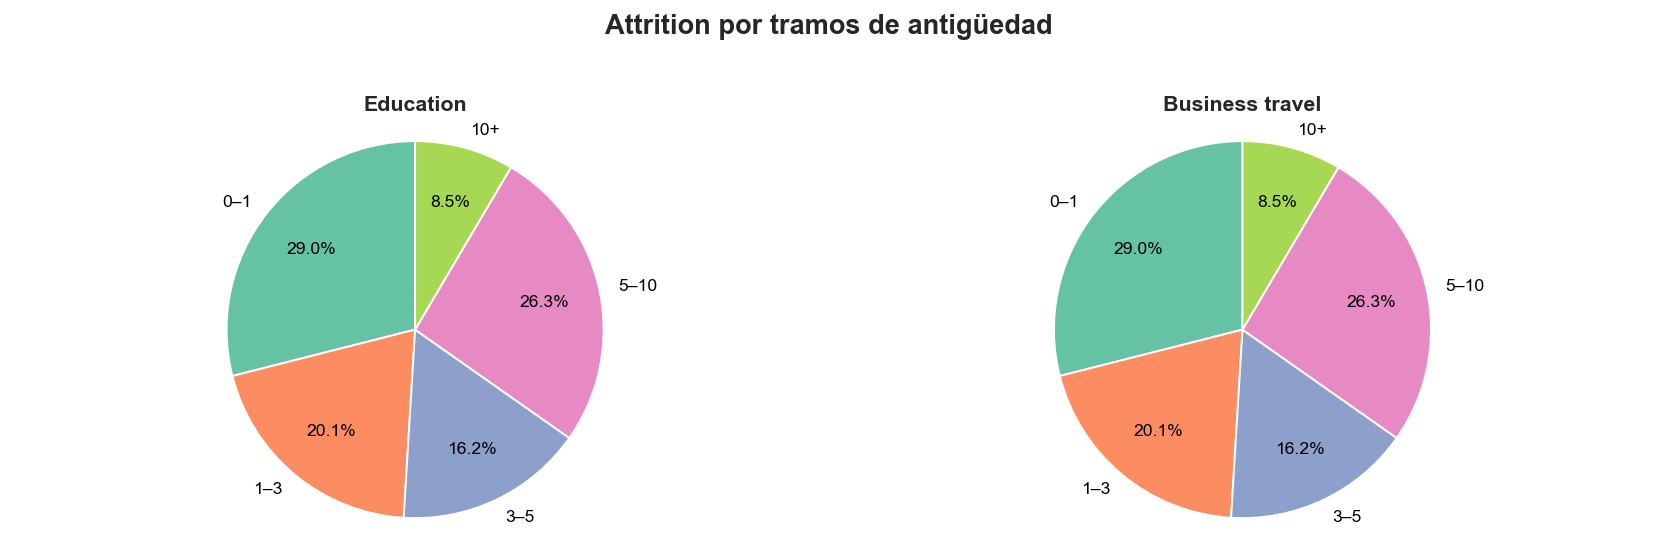

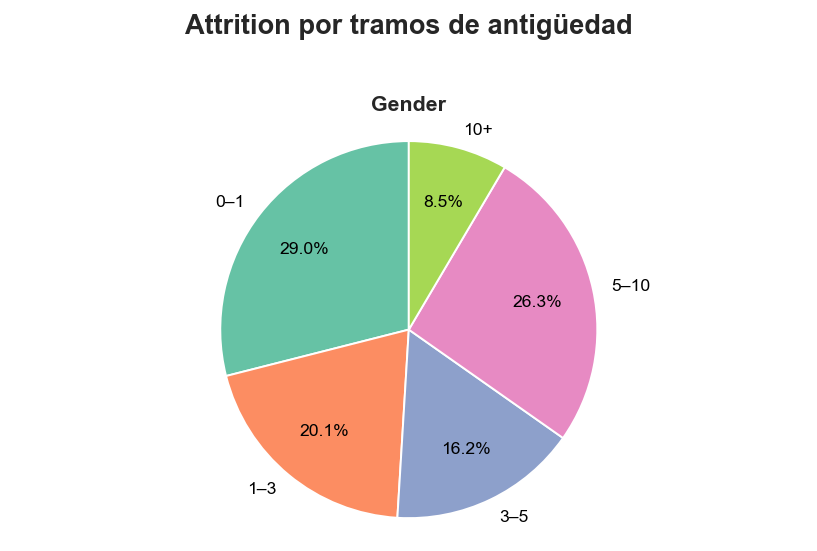

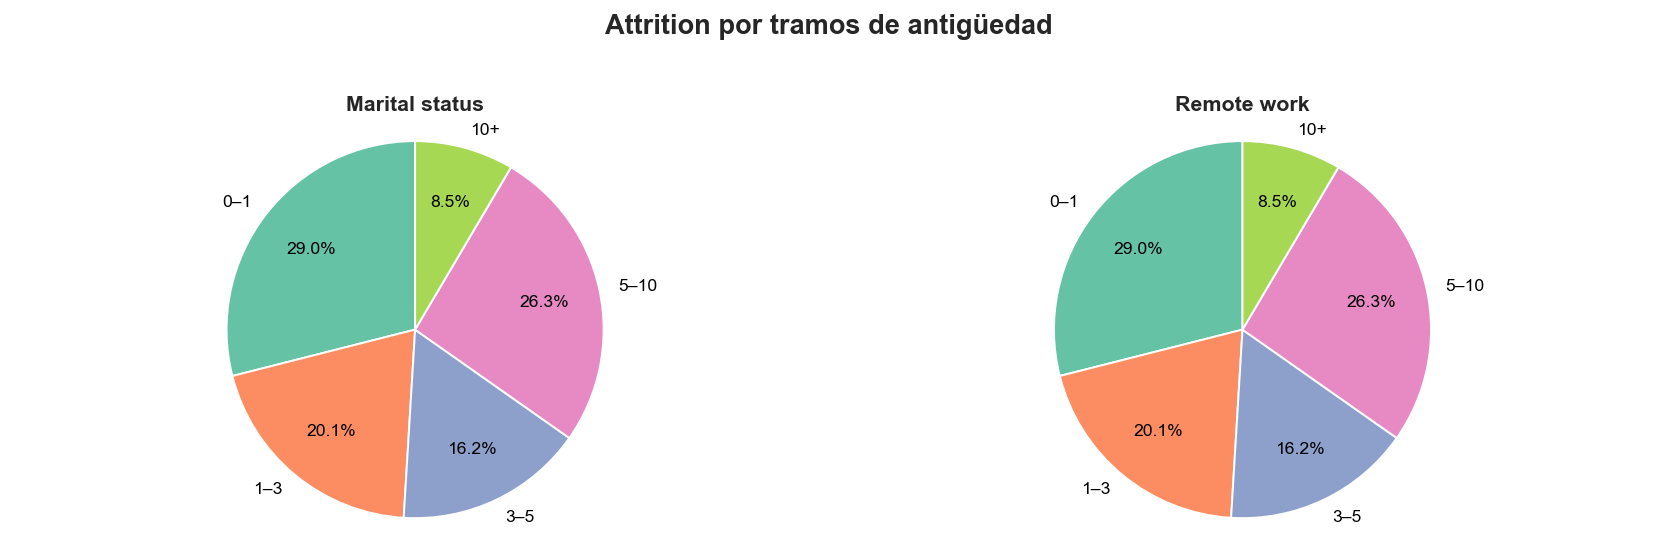

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# =========================
# Estética
# =========================
sns.set_theme(style="whitegrid")
BASE_PALETTE = sns.color_palette("Set2")

# =========================
# Localización segura de columnas
# =========================
def to_str_or_none(x):
    if x is None:
        return None
    if isinstance(x, str):
        return x
    if isinstance(x, pd.Series):
        try:
            vals = x.dropna().unique().tolist()
            if len(vals) == 1 and isinstance(vals[0], str):
                return vals[0]
            return None
        except Exception:
            return None
    if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1 and isinstance(x[0], str):
        return x[0]
    return None

def find_col_safe(candidates, columns):
    for cand in candidates:
        name = to_str_or_none(cand)
        if isinstance(name, str) and name in columns:
            return name
    return None

_cols = df.columns

attr_col   = find_col_safe([resolved.get("attrition", None) if isinstance(resolved, dict) else None,
                            "Attrition","attrition"], _cols)
jobrole_col= find_col_safe([resolved.get("jobrole", None) if isinstance(resolved, dict) else None,
                            "Job role","JobRole","Job Role"], _cols)
overtime_col=find_col_safe([resolved.get("overtime", None) if isinstance(resolved, dict) else None,
                            "Overtime"], _cols)
edu_col    = find_col_safe([resolved.get("education", None) if isinstance(resolved, dict) else None,
                            "Education"], _cols)
btravel_col= find_col_safe([resolved.get("business_travel", None) if isinstance(resolved, dict) else None,
                            "Business travel","BusinessTravel"], _cols)
gender_col = find_col_safe([resolved.get("gender", None) if isinstance(resolved, dict) else None,
                            "Gender"], _cols)
marital_col= find_col_safe([resolved.get("marital_status", None) if isinstance(resolved, dict) else None,
                            "Marital status","MaritalStatus"], _cols)
remote_col = find_col_safe([resolved.get("remote_work", None) if isinstance(resolved, dict) else None,
                            "Remote work","RemoteWork","Remote Work"], _cols)
tenure_col = find_col_safe([resolved.get("years_at_company", None) if isinstance(resolved, dict) else None,
                            "Years at company","YearsAtCompany","Years at Company"], _cols)

cat_cols = [c for c in [jobrole_col, overtime_col, edu_col, btravel_col, gender_col, marital_col, remote_col] if isinstance(c, str)]

if (attr_col is None) or (tenure_col is None) or (len(cat_cols) == 0):
    raise ValueError("Faltan columnas necesarias (attrition / categorías / antigüedad). Revisa nombres en df.columns o 'resolved'.")

# =========================
# Normaliza Attrition 0/1
# =========================
attr_s = df[attr_col].astype("string").str.strip().str.lower()
map_yesno = {"yes":1,"y":1,"true":1,"1":1,"si":1,"sí":1,"no":0,"n":0,"false":0,"0":0}
attr_num = pd.to_numeric(df[attr_col], errors="coerce")
attr = attr_s.map(map_yesno)
attr = attr.fillna(attr_num).fillna(0).astype(int).clip(0,1)
df["_attr_bin"] = attr

# =========================
# Bins de antigüedad
# =========================
ten = pd.to_numeric(df[tenure_col], errors="coerce")
bins = [-0.001, 1, 3, 5, 10, np.inf]
ten_labels = ["0–1", "1–3", "3–5", "5–10", "10+"]
df["_ten_bin"] = pd.cut(ten, bins=bins, labels=ten_labels, right=True, include_lowest=True, ordered=True)

# =========================
# Helpers visuales
# =========================
def chunk_list(seq, pattern=(2,2,1)):
    out, i = [], 0
    while i < len(seq):
        for k in pattern:
            if i >= len(seq): break
            out.append(seq[i:i+k]); i += k
    return out

def order_for_series(s: pd.Series):
    if pd.api.types.is_categorical_dtype(s):
        return [str(x) for x in s.cat.categories]
    vals = s.dropna().astype(str).unique().tolist()
    return sorted(vals, key=lambda x: (len(x), x))

def percent_axis(ax):
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(PercentFormatter(100))

def tidy_xticks(ax, rotation):
    if rotation == 0:
        ax.margins(x=0.06)
        for lab in ax.get_xticklabels():
            lab.set_rotation(0); lab.set_ha("center"); lab.set_va("top")
    else:
        ax.margins(x=0.04)
        for lab in ax.get_xticklabels():
            lab.set_rotation(rotation); lab.set_ha("right"); lab.set_va("top")

# ======================================================
# 1) Barras multicolor — % Attrition por categoría
# ======================================================
def plot_attrition_by_category():
    blocks = chunk_list(cat_cols, (2,2,1))
    for cols in blocks:
        k = len(cols)
        ncols = 2 if k > 1 else 1
        nrows = (k + ncols - 1)//ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
        axes = np.atleast_1d(axes).ravel()

        for ax, c in zip(axes, cols):
            dff = df[[c, "_attr_bin"]].dropna().copy()
            if dff.shape[0] == 0:
                ax.axis("off"); ax.set_title(c); continue

            grp = (
                dff.groupby(c, observed=True)["_attr_bin"]
                   .mean().mul(100)
                   .reset_index(name="attrition_pct")
            )
            if grp.shape[0] == 0:
                ax.axis("off"); ax.set_title(c); continue

            x_order = order_for_series(df[c])
            grp[c] = grp[c].astype("string")

            pal = sns.color_palette("Set2", max(3, len(x_order)))
            color_map = {cat: pal[i % len(pal)] for i, cat in enumerate(x_order)}
            bar_colors = grp[c].map(color_map).tolist()  # list explícita (evita ambigüedad)

            sns.barplot(
                data=grp,
                x=c, y="attrition_pct",
                order=x_order,
                palette=bar_colors,   # lista de colores alineada con las filas
                edgecolor="white",
                ax=ax
            )

            ax.set_title(c, fontsize=11, fontweight="semibold")
            ax.set_xlabel(c)
            ax.set_ylabel("Attrition (%)")
            percent_axis(ax)

            rot = 0 if (remote_col is not None and c == remote_col) else 28
            tidy_xticks(ax, rotation=rot)

        for extra in axes[len(cols):]:
            extra.axis("off")

        fig.suptitle("Attrition por categoría", fontsize=14, fontweight="bold")
        fig.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

# ======================================================
# 2) Tartas — distribución de attritions por tramos de antigüedad
# ======================================================
def plot_attrition_pies_by_tenure():
    blocks = chunk_list(cat_cols, (2,2,1))
    for cols in blocks:
        k = len(cols)
        ncols = 2 if k > 1 else 1
        nrows = (k + ncols - 1)//ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
        axes = np.atleast_1d(axes).ravel()

        for ax, c in zip(axes, cols):
            dff = df[[c, "_ten_bin", "_attr_bin"]].dropna().copy()
            if dff.shape[0] == 0:
                ax.axis("off"); ax.set_title(c); continue

            grp = (
                dff.groupby("_ten_bin", observed=True)["_attr_bin"]
                   .sum()
                   .reset_index(name="attritions")
            )
            total_attr = float(grp["attritions"].sum())
            if total_attr <= 0.0:
                ax.axis("off"); ax.set_title(c); continue

            grp["pct"] = grp["attritions"] / total_attr * 100.0

            labels = grp["_ten_bin"].astype(str).tolist()
            sizes  = grp["pct"].tolist()
            palette = sns.color_palette("Set2", len(sizes))

            wedges, texts, autotexts = ax.pie(
                sizes,
                labels=labels,
                autopct=lambda p: f"{p:.1f}%",
                colors=palette,
                startangle=90,
                wedgeprops={'edgecolor': 'white'},
                textprops={'fontsize': 9, 'color': 'black'},
                pctdistance=0.7
            )

            ax.set_title(f"{c}", fontsize=11, fontweight="semibold")
            ax.axis("equal")

        for extra in axes[len(cols):]:
            extra.axis("off")

        fig.suptitle("Attrition por tramos de antigüedad", fontsize=14, fontweight="bold")
        fig.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

# =========================
# Ejecutar
# =========================
plot_attrition_by_category()
plot_attrition_pies_by_tenure()


### Interpretación de los resultados

- **Diferencias por categoría:**  
  La rotación no es homogénea entre colectivos. Algunos grupos presentan **tasas visiblemente superiores** (p. ej., ciertos roles o quienes realizan **overtime**), lo que sugiere revisar **carga de trabajo, expectativas y políticas de conciliación**.  
  En categorías como **Business travel** o **Remote work**, se aprecian **brechas** que pueden relacionarse con **exigencia de desplazamientos**, percepción de **flexibilidad** o **soporte del equipo**.

- **Antigüedad (momentos críticos):**  
  El mapa por tramos de antigüedad muestra **picos de rotación** en momentos concretos del ciclo (por ejemplo, **primer año** o entre **1–3 años**), típicos de fases de ajuste y consolidación. Estos puntos son **prioritarios** para reforzar **onboarding, mentoring y rutas de carrera**.

- **Líneas de acción sugeridas:**  
  1) **Intervención focalizada** en los grupos con mayor rotación: análisis cualitativo rápido (entrevistas/cuestiones “pulse”), ajustes de carga y liderazgo cercano.  
  2) **Prevención por cohortes de antigüedad:** programas específicos en los tramos donde el mapa indica el **salto de salida**.  
  3) **Flexibilidad y reconocimiento:** si **overtime** o **viajes** coinciden con mayor rotación, compensar con medidas de descanso, planificación y reconocimiento explícito.

> En conjunto, las gráficas señalan **dónde duele más** la rotación y **cuándo** ocurre. Actuar sobre estos focos debería **reducir salidas evitables** y mejorar la **experiencia del empleado**.


## Relación entre Ingresos y Satisfacción

En este análisis observamos la relación entre el **nivel de ingresos** de los empleados  
y su **satisfacción laboral**.

Usamos dos perspectivas complementarias:
1. **Dispersión con línea de regresión:** permite ver si a medida que suben los ingresos también tiende a subir (o bajar) la satisfacción.
2. **Cuartiles de ingreso:** facilita comparar la satisfacción media de los empleados de ingresos más bajos frente a los de ingresos más altos.

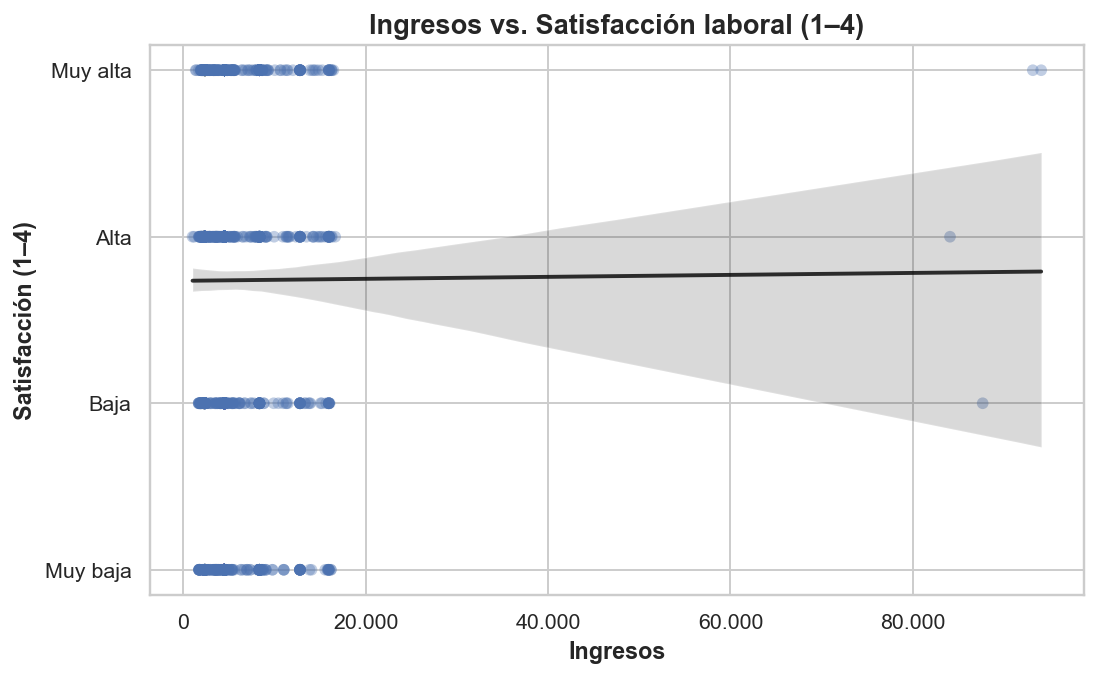

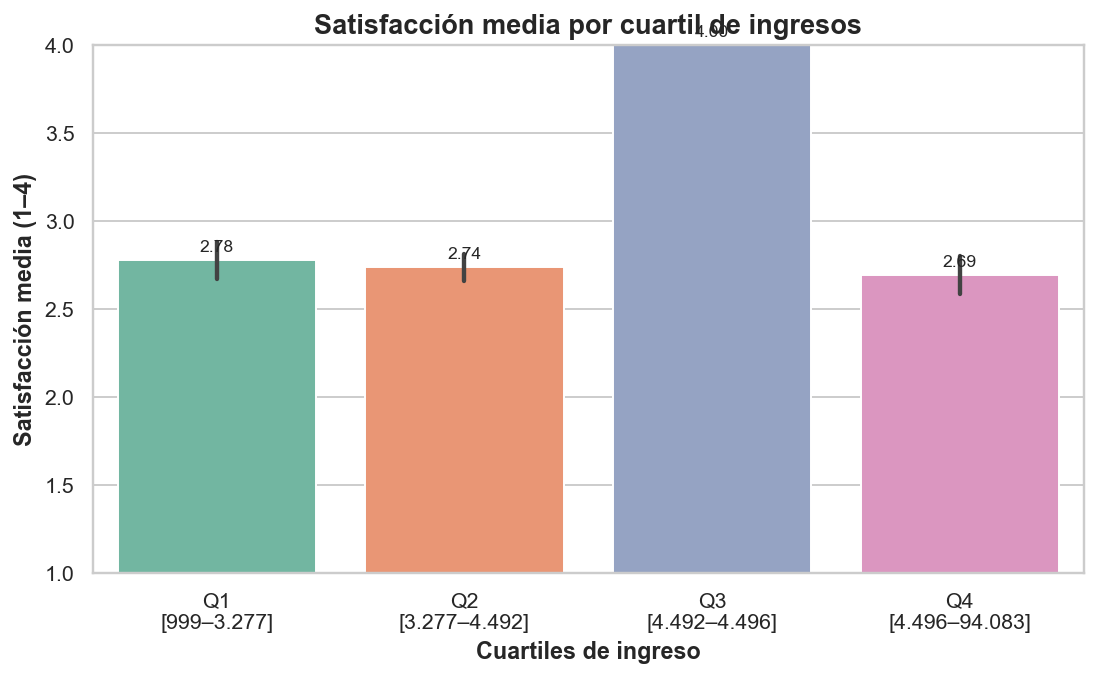

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")
PALETTE = sns.color_palette("Set2")

# =========================
# Localización segura de columnas
# =========================
def to_str_or_none(x):
    if x is None: return None
    if isinstance(x, str): return x
    if isinstance(x, pd.Series):
        vals = x.dropna().unique().tolist()
        return vals[0] if len(vals)==1 and isinstance(vals[0], str) else None
    if isinstance(x, (list, tuple, np.ndarray)) and len(x)==1 and isinstance(x[0], str):
        return x[0]
    return None

def find_col_safe(candidates, columns):
    for cand in candidates:
        name = to_str_or_none(cand)
        if isinstance(name, str) and name in columns:
            return name
    return None

cols = df.columns

income_col = find_col_safe([
    (resolved.get("income") if isinstance(resolved, dict) else None),
    "Monthly income","Monthly Income","MonthlyIncome",
    "Income","Salary","Base pay","Base Pay","BasePay"
], cols)

sat_col = find_col_safe([
    "Job satisfaction","Job Satisfaction","JobSatisfaction"
], cols)

jobrole_col = find_col_safe([
    (resolved.get("jobrole") if isinstance(resolved, dict) else None),
    "Job role","Job Role","JobRole"
], cols)

if income_col is None or sat_col is None:
    raise ValueError("No se encontraron las columnas de Ingresos y/o Job satisfaction en df.columns.")

# =========================
# 1) Satisfacción → escala 1–4 (robusto)
# =========================
labels_to_num = {
    "muy baja":1, "baja":2, "alta":3, "muy alta":4,
    "malo":1, "regular":2, "bueno":3, "excelente":4  # por si viene de Work-life, no afecta aquí
}
def satisfaction_to_num(s):
    # intenta ya numérico
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any():
        # recorta a 1..4 si viene con otros valores
        s_num = s_num.where(s_num.between(1,4), np.nan)
        return s_num
    # si no, intenta mapear etiquetas
    s_str = s.astype("string").str.strip().str.lower()
    mapped = s_str.map(labels_to_num)
    return mapped

df["_sat_num"] = satisfaction_to_num(df[sat_col]).astype("float")
# si quedó algo vacío, lo eliminamos para estos plots
dff = df[[income_col, "_sat_num"]].dropna().copy()
if jobrole_col is not None and jobrole_col in df.columns:
    dff[jobrole_col] = df.loc[dff.index, jobrole_col]

# Ingresos a num
dff[income_col] = pd.to_numeric(dff[income_col], errors="coerce")
dff = dff.dropna(subset=[income_col, "_sat_num"])

# =========================
# 2) Dispersión + regresión
# =========================
plt.figure(figsize=(8,5))
# Dispersión con algo de transparencia
sns.scatterplot(
    data=dff,
    x=income_col, y="_sat_num",
    alpha=0.35, edgecolor="none"
)
# Recta de regresión (lineal)
sns.regplot(
    data=dff,
    x=income_col, y="_sat_num",
    scatter=False, color="black", line_kws={"linewidth":2, "alpha":0.8}
)

plt.title("Ingresos vs. Satisfacción laboral (1–4)", fontsize=14, fontweight="bold")
plt.xlabel("Ingresos")
plt.ylabel("Satisfacción (1–4)")

# Ticks de satisfacción con etiquetas en español
plt.yticks([1,2,3,4], ["Muy baja","Baja","Alta","Muy alta"])

# Formato de ingresos con separador de miles
def miles(x, pos): 
    try: return f"{int(x):,}".replace(",", ".")
    except: return str(x)
plt.gca().xaxis.set_major_formatter(FuncFormatter(miles))

plt.tight_layout()
plt.show()

# =========================
# 3) Cuartiles de ingreso → barra de medias
# =========================
# Creamos cuartiles (qcut descarta NaN y crea bins balanceados)
q = pd.qcut(dff[income_col], q=4, duplicates="drop")
# Etiquetas con los rangos numéricos
intervals = q.cat.categories
quartile_labels = [f"Q{i+1}\n[{int(iv.left):,}–{int(iv.right):,}]".replace(",", ".") for i, iv in enumerate(intervals)]
dff["_income_q"] = q.cat.rename_categories(quartile_labels)

plt.figure(figsize=(8,5))
sns.barplot(
    data=dff,
    x="_income_q", y="_sat_num",
    palette=PALETTE,
    errorbar=("ci", 95),  # IC 95%
    edgecolor="white"
)

plt.title("Satisfacción media por cuartil de ingresos", fontsize=14, fontweight="bold")
plt.xlabel("Cuartiles de ingreso")
plt.ylabel("Satisfacción media (1–4)")
plt.ylim(1,4)

# Etiquetas sobre cada barra con la media
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x()+p.get_width()/2, height),
                ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")

plt.tight_layout()
plt.show()





### Interpretación de los resultados

- **Tendencia general:**  
  La nube de puntos muestra la **variabilidad individual**, mientras que la **línea de regresión** indica la tendencia global.  
  En este caso, la pendiente sugiere que la **satisfacción tiende a aumentar ligeramente a medida que crecen los ingresos**, aunque la dispersión revela que **el ingreso no es el único factor determinante**.

- **Diferencias entre cuartiles:**  
  El gráfico por cuartiles evidencia que los empleados en los **tramos más altos de ingreso** tienden a presentar **niveles medios de satisfacción algo superiores** a los de los tramos más bajos.  
  La superposición entre cajas muestra, no obstante, que **existen personas muy satisfechas también en los cuartiles bajos**, lo que indica la importancia de otros factores (liderazgo, cultura, flexibilidad, etc.).

- **Conclusión práctica:**  
  Las políticas salariales pueden contribuir a la mejora de la satisfacción, pero **no bastan por sí solas**.  
  Conviene reforzarlas con iniciativas **no monetarias** (desarrollo profesional, reconocimiento, conciliación) para elevar la satisfacción en todos los segmentos de ingresos.